<a href="https://colab.research.google.com/github/kundajelab/revcomp_experiments/blob/master/CTCG_RegressionExample_Standard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! zcat peaks_with_signal_SPI1.bed.gz | perl -lane 'print $F[0]."\t".($F[1]+$F[9])."\t".($F[1]+$F[9])."\t+\t".($F[6])' | egrep -w 'chr1|chr2|chr3|chr4|chr5|chr6|chr7|chr8|chr9|chr10|chr11|chr12|chr13|chr14|chr15|chr16|chr17|chr18|chr19|chr20|chr21|chr22|chrX|chrY' | gzip -c > summits_with_signal_SPI1.bed.gz

#We split into training/test/validation set by chromosome
!zcat summits_with_signal_SPI1.bed.gz | egrep -w 'chr1|chr8|chr21' | gzip -c > test_summits_with_signal_SPI1.bed.gz
!zcat summits_with_signal_SPI1.bed.gz | egrep -w 'chr22' | gzip -c > valid_summits_with_signal_SPI1.bed.gz
!zcat summits_with_signal_SPI1.bed.gz | egrep -w -v 'chr1|chr8|chr21|chr22' | gzip -c > train_summits_with_signal_SPI1.bed.gz

In [1]:
from seqdataloader.batchproducers import coordbased
import gzip
import numpy as np

class ColsInBedFile(
    coordbased.coordstovals.core.AbstractSingleNdarrayCoordsToVals):
    def __init__(self, gzipped_bed_file, **kwargs):
        super(ColsInBedFile, self).__init__(**kwargs)
        self.gzipped_bed_file = gzipped_bed_file
        coords_to_vals = {}
        for row in gzip.open(gzipped_bed_file, 'rb'):
            row = row.decode("utf-8").rstrip()
            split_row = row.split("\t")
            chrom_start_end = split_row[0]+":"+split_row[1]+"-"+split_row[2]
            vals = np.array([float(x) for x in split_row[4:]])
            coords_to_vals[chrom_start_end] = vals
        self.coords_to_vals = coords_to_vals
        
    def _get_ndarray(self, coors):
        to_return = []
        for coor in coors:
            chrom_start_end = (coor.chrom+":"
                               +str(coor.start)+"-"+str(coor.end))
            to_return.append(self.coords_to_vals[chrom_start_end])
        return np.array(to_return)
    
    
inputs_coordstovals = coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
  genome_fasta_path= '/mnt/data/annotations/by_release/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta',
  center_size_to_use=1000)

targets_coordstovals_SPI1 = ColsInBedFile(
       gzipped_bed_file="summits_with_signal_SPI1.bed.gz")
            
keras_train_batch_generator_SPI1 = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer=coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
      bed_file="train_summits_with_signal_SPI1.bed.gz",
      #coord_batch_transformer=coordbased.coordbatchtransformers.ReverseComplementAugmenter(),
      batch_size=64,
      shuffle_before_epoch=True,
      seed=1234
    ),
    inputs_coordstovals=inputs_coordstovals,
    targets_coordstovals=targets_coordstovals_SPI1
)


keras_valid_batch_generator_SPI1 = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
        bed_file="valid_summits_with_signal_SPI1.bed.gz", 
        batch_size=64, 
        shuffle_before_epoch=True, 
        seed=1234
    ),
    inputs_coordstovals=inputs_coordstovals, 
    targets_coordstovals=targets_coordstovals_SPI1
)

keras_test_batch_generator_SPI1 = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
        bed_file="test_summits_with_signal_SPI1.bed.gz", 
        batch_size = 64, 
        shuffle_before_epoch = True, 
        seed = 1234
    ), 
    inputs_coordstovals = inputs_coordstovals, 
    targets_coordstovals = targets_coordstovals_SPI1
)


keras_train_batch_generator_augment_SPI1 = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer=coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
      bed_file="train_summits_with_signal_SPI1.bed.gz",
      coord_batch_transformer=coordbased.coordbatchtransformers.ReverseComplementAugmenter(),
      batch_size=128,
      shuffle_before_epoch=True,
      seed=1234
    ),
    inputs_coordstovals=inputs_coordstovals,
    targets_coordstovals=targets_coordstovals_SPI1
)


keras_valid_batch_generator_augment_SPI1 = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
        bed_file="valid_summits_with_signal_SPI1.bed.gz",
        coord_batch_transformer=coordbased.coordbatchtransformers.ReverseComplementAugmenter(),
        batch_size=128, 
        shuffle_before_epoch=True, 
        seed=1234
    ),
    inputs_coordstovals=inputs_coordstovals, 
    targets_coordstovals=targets_coordstovals_SPI1
)

keras_test_batch_generator_augment_SPI1 = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
        bed_file="test_summits_with_signal_SPI1.bed.gz",
        coord_batch_transformer=coordbased.coordbatchtransformers.ReverseComplementAugmenter(),
        batch_size = 128, 
        shuffle_before_epoch = True, 
        seed = 1234
    ), 
    inputs_coordstovals = inputs_coordstovals, 
    targets_coordstovals = targets_coordstovals_SPI1
)



targets_coordstovals_CTCF = ColsInBedFile(
       gzipped_bed_file="summits_with_signal.bed.gz")
            
keras_train_batch_generator_CTCF = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer=coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
      bed_file="train_summits_with_signal.bed.gz",
      #coord_batch_transformer=coordbased.coordbatchtransformers.ReverseComplementAugmenter(),
      batch_size=64,
      shuffle_before_epoch=True,
      seed=1234
    ),
    inputs_coordstovals=inputs_coordstovals,
    targets_coordstovals=targets_coordstovals_CTCF
)


keras_valid_batch_generator_CTCF = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
        bed_file="valid_summits_with_signal.bed.gz", 
        batch_size=64, 
        shuffle_before_epoch=True, 
        seed=1234
    ),
    inputs_coordstovals=inputs_coordstovals, 
    targets_coordstovals=targets_coordstovals_CTCF
)

keras_test_batch_generator_CTCF = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
        bed_file="test_summits_with_signal.bed.gz", 
        batch_size = 64, 
        shuffle_before_epoch = True, 
        seed = 1234
    ), 
    inputs_coordstovals = inputs_coordstovals, 
    targets_coordstovals = targets_coordstovals_CTCF
)


keras_train_batch_generator_augment_CTCF = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer=coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
      bed_file="train_summits_with_signal.bed.gz",
      coord_batch_transformer=coordbased.coordbatchtransformers.ReverseComplementAugmenter(),
      batch_size=128,
      shuffle_before_epoch=True,
      seed=1234
    ),
    inputs_coordstovals=inputs_coordstovals,
    targets_coordstovals=targets_coordstovals_CTCF
)


keras_valid_batch_generator_augment_CTCF = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
        bed_file="valid_summits_with_signal.bed.gz",
        coord_batch_transformer=coordbased.coordbatchtransformers.ReverseComplementAugmenter(),
        batch_size=128, 
        shuffle_before_epoch=True, 
        seed=1234
    ),
    inputs_coordstovals=inputs_coordstovals, 
    targets_coordstovals=targets_coordstovals_CTCF
)

keras_test_batch_generator_augment_CTCF = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
        bed_file="test_summits_with_signal.bed.gz",
        coord_batch_transformer=coordbased.coordbatchtransformers.ReverseComplementAugmenter(),
        batch_size = 128, 
        shuffle_before_epoch = True, 
        seed = 1234
    ), 
    inputs_coordstovals = inputs_coordstovals, 
    targets_coordstovals = targets_coordstovals_CTCF
)

Using TensorFlow backend.


In [2]:
y_test_SPI1 = np.array([val for batch in keras_test_batch_generator_SPI1 for val in batch[1]], dtype = 'float32') 
y_test_CTCF = np.array([val for batch in keras_test_batch_generator_CTCF for val in batch[1]], dtype = 'float32') 

In [3]:
y_test_augment_SPI1 = np.array([val for batch in keras_test_batch_generator_augment_SPI1 for val in batch[1]], dtype = 'float32') 
y_test_augment_CTCF = np.array([val for batch in keras_test_batch_generator_augment_CTCF for val in batch[1]], dtype = 'float32') 

In [4]:
import keras 
import keras_genomics
import numpy as np
import keras.layers as k1
import simdna

from keras import backend as K 
from keras.layers.core import Dropout 
from keras.layers.core import Flatten
from keras.layers import Input
from keras.engine import Layer
from keras.models import Sequential 
from keras.engine.base_layer import InputSpec
from keras.models import Model
from keras.models import load_model

In [5]:
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import ops
import numbers
from tensorflow.python.framework import tensor_util
from scipy.stats import spearmanr
def _get_noise_shape(x, noise_shape):
  # If noise_shape is none return immediately.
  if noise_shape is None:
    return array_ops.shape(x)

  try:
    # Best effort to figure out the intended shape.
    # If not possible, let the op to handle it.
    # In eager mode exception will show up.
    noise_shape_ = tensor_shape.as_shape(noise_shape)
  except (TypeError, ValueError):
    return noise_shape

  if x.shape.dims is not None and len(x.shape.dims) == len(noise_shape_.dims):
    new_dims = []
    for i, dim in enumerate(x.shape.dims):
      if noise_shape_.dims[i].value is None and dim.value is not None:
        new_dims.append(dim.value)
      else:
        new_dims.append(noise_shape_.dims[i].value)
    return tensor_shape.TensorShape(new_dims)

  return noise_shape

class MCRCDropout(Layer):
    """Applies MC Dropout to the input.
       The applied noise vector is symmetric to reverse complement symmetry
       Class structure only slightly adapted 
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    Remains active ative at test time so sampling is required
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)
    """
    def __init__(self, rate, noise_shape=None, seed=None, **kwargs):
        super(MCRCDropout, self).__init__(**kwargs)
        self.rate = min(1., max(0., rate))
        self.noise_shape = noise_shape
        self.seed = seed
        self.supports_masking = True
        
    def build(self, input_shape):
        self.num_input_chan = input_shape[2]
        super(MCRCDropout, self).build(input_shape)

    def _get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape

        symbolic_shape = K.shape(inputs)
        noise_shape = [symbolic_shape[axis] if shape is None else shape
                       for axis, shape in enumerate(self.noise_shape)]
        return tuple(noise_shape)

    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            import numpy as np
            noise_shape = self._get_noise_shape(inputs)
            x = inputs
            seed = self.seed
            keep_prob = 1. - self.rate
            if seed is None:
                seed = np.random.randint(10e6)
            # the dummy 1. works around a TF bug
            # (float32_ref vs. float32 incompatibility)
            x= x*1
            name = None
            with ops.name_scope(name, "dropout", [x]) as name:
                x = ops.convert_to_tensor(x, name="x")
                if not x.dtype.is_floating:
                    raise ValueError("x has to be a floating point tensor since it's going to"
                       " be scaled. Got a %s tensor instead." % x.dtype)
                if isinstance(keep_prob, numbers.Real) and not 0 < keep_prob <= 1:
                    raise ValueError("keep_prob must be a scalar tensor or a float in the "
                       "range (0, 1], got %g" % keep_prob)
                keep_prob = ops.convert_to_tensor(
                             keep_prob, dtype=x.dtype, name="keep_prob")
                keep_prob.get_shape().assert_is_compatible_with(tensor_shape.scalar())

                # Do nothing if we know keep_prob == 1
                if tensor_util.constant_value(keep_prob) == 1:
                    return x

                noise_shape = _get_noise_shape(x, noise_shape)
                # uniform [keep_prob, 1.0 + keep_prob)
                random_tensor = keep_prob
                random_tensor += random_ops.random_uniform(
                noise_shape, seed=seed, dtype=x.dtype)
               
                # 0. if [keep_prob, 1.0) and 1. if [1.0, 1.0 + keep_prob)
                binary_tensor = math_ops.floor(random_tensor)
                dim = binary_tensor.shape[2]//2

                symmetric_binary = K.concatenate(
                    tensors = [
                      binary_tensor[:,:,int(self.num_input_chan/2):], 
                      binary_tensor[:,:,int(self.num_input_chan/2):][::,::-1,::-1]], 
                  axis=2)
                ret = math_ops.div(x, keep_prob) * symmetric_binary
                
                return ret


    def get_config(self):
        config = {'rate': self.rate,
                  'noise_shape': self.noise_shape,
                  'seed': self.seed}
        base_config = super(MCRCDropout, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [6]:
class RevCompSpatialDropout1D(Dropout): 
    def __init__(self, rate,**kwargs): 
        super(RevCompSpatialDropout1D, self).__init__(rate, **kwargs)
        self.seed = 3
        self.input_spec = InputSpec(ndim = 3)

    def _get_noise_shape(self, inputs): 
        input_shape = K.shape(inputs)
        noise_shape = (input_shape[0], 1, 1, int(self.num_input_chan/2)) 
        return noise_shape
        
    def build(self, input_shape):
        self.num_input_chan = input_shape[2]
        self.input_len = input_shape[1]
        super(RevCompSpatialDropout1D, self).build(input_shape)

    def call(self, inputs, training=None): 
        inputs_fwdandrevconcat = K.concatenate(
                tensors = [
                    inputs[:,:,None,:int(self.num_input_chan/2)],
                    inputs[:,:,None,int(self.num_input_chan/2):][:,:,:,::-1]],
                axis=2)

        if 0. < self.rate < 1.: 
            noise_shape = self._get_noise_shape(inputs)
            def dropped_inputs(): 
                dropped = K.dropout(inputs_fwdandrevconcat,
                                    self.rate, noise_shape, seed = self.seed)
                dropped = K.reshape(dropped, (-1, int(self.input_len), int(self.num_input_chan)))
                return K.concatenate(
                    tensors = [
                        dropped[:,:,:int(self.num_input_chan/2)],
                        dropped[:,:,int(self.num_input_chan/2):][:,:,::-1]],
                    axis=-1)

            return K.in_train_phase(dropped_inputs, inputs, training = training)

        return inputs

In [7]:
class RevCompSumPool(Layer): 
    def __init__(self, **kwargs): 
        super(RevCompSumPool, self).__init__(**kwargs)

    def build(self, input_shape):
        self.num_input_chan = input_shape[2]
        super(RevCompSumPool, self).build(input_shape)

    def call(self, inputs): 
        #divide by sqrt 2 for variance preservation
        inputs = (inputs[:,:,:int(self.num_input_chan/2)] + inputs[:,:,int(self.num_input_chan/2):][:,::-1,::-1])/(1.41421356237)
        return inputs
      
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], int(input_shape[2]/2))

In [8]:
class RevComp(Layer): 
    def __init__(self, **kwargs): 
      super(RevComp, self).__init__(**kwargs)

    def build(self, input_shape):
      super(RevComp, self).build(input_shape)

    def call(self, inputs): 
      return inputs[:,::-1,::-1]
      
    def compute_output_shape(self, input_shape):
      return input_shape

In [9]:
def predict_with_uncertainty(f, x, no_classes, n_iter=100):
    result = np.zeros((n_iter,) + (x.shape[0], no_classes) )

    for i in range(n_iter):
        result[i,:, :] = f((x, 1))[0]

    prediction = result.mean(axis=0)
    uncertainty = result.std(axis=0)
    return prediction

def spearmanr_all(y_test, model, test_batch_generator): 
#     model = load_model(name, custom_objects)
    f2 = K.function([model.layers[0].input, K.learning_phase()],
                    [model.layers[-1].output])
    
    y_pred = np.concatenate(np.array([predict_with_uncertainty(f2, test_batch_generator[i][0], 1) for i in range(len(test_batch_generator))]), axis = 0)
    rho, pval = spearmanr(y_test, y_pred)
    return rho

In [10]:
custom_objects = {'RevCompConv1D':keras_genomics.layers.RevCompConv1D,
                  'RevCompSumPool':RevCompSumPool,
                  'MCRCDropout':MCRCDropout,
                  'RevCompSpatialDropout1D': RevCompSpatialDropout1D,
                  'RevComp':RevComp}

In [11]:
kernel_size = 15
filters= 15
input_length = 1000

from numpy.random import seed
from tensorflow import set_random_seed
from keras.callbacks import EarlyStopping, History, ModelCheckpoint

In [12]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [12]:
import json

In [30]:
# filenames = {'reg_dropout_', 'augment_dropout_', 'augment_spatial_dropout_', 'rc_spatial_dropout_orig_','rc_spatial_dropout_new_',
#              'rc_standard_mcdropout_', 'rc_standard_dropout_','siamese_spatial_dropout_'}

In [13]:
inputs_coordstovals.ltrdict = {
           'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0],'R': [0.5,0,0.5,0],'Y':[0,0.5,0,0.5]}

In [14]:
dropout_rate = 0.2
seed_num = 1000

In [101]:
data = {
        "filename": "rc_no_dropout",
        "dataset": "SPI1",
        "augment": False,
        "siamese": False,
        "rev_comp": True,
        "dropout": False,
        "mc_dropout": False,
        "spatial_dropout": False,
        "rc_spatial_dropout": False,
        "dropout_rate": 0.2,
        "num_conv": 3,
        "filters": 15,
        "kernel_size": 15,
        "pool_size": 40,
        "pooling": "max",
        "num_epochs": 300,
        "patience": 60,
        "seed_num": 1944,
        "strides": 40,
        "units": 100,
        "correlation": 0 
        }

In [20]:
def test(data):
    num_conv = data["num_conv"]
    dataset = data["dataset"]
    augment =  data["augment"]
    dropout = data["dropout"]
    dropout_rate = data["dropout_rate"]
    filename = data["filename"]
    filters = data["filters"]
    kernel_size = data["kernel_size"]
    mc_dropout = data["mc_dropout"]
    num_epochs = data["num_epochs"]
    patience = data["patience"]
    pool_size = data["pool_size"]
    pooling = data["pooling"]
    rev_comp = data["rev_comp"]
    seed_num = (int)(np.random.uniform(1000, 10000))
    data["seed_num"] = seed_num
    siamese = data["siamese"]
    spatial_dropout = data["spatial_dropout"]
    rc_spatial_dropout = data["rc_spatial_dropout"]
    strides = data["strides"]
    units = data["units"]
    
    train_batch_generator = keras_train_batch_generator_CTCF
    valid_batch_generator = keras_valid_batch_generator_CTCF
    test_batch_generator = keras_test_batch_generator_CTCF
    y_test = y_test_CTCF
    
    if dataset == "CTCF": 
        if augment: 
            train_batch_generator = keras_train_batch_generator_augment_CTCF
            valid_batch_generator = keras_valid_batch_generator_augment_CTCF
            test_batch_generator = keras_test_batch_generator_augment_CTCF
            y_test = y_test_augment_CTCF
    elif dataset == "SPI1": 
        if augment: 
            train_batch_generator = keras_train_batch_generator_augment_SPI1
            valid_batch_generator = keras_valid_batch_generator_augment_SPI1
            test_batch_generator = keras_test_batch_generator_augment_SPI1
            y_test = y_test_augment_SPI1
        else:
            train_batch_generator = keras_train_batch_generator_SPI1
            valid_batch_generator = keras_valid_batch_generator_SPI1
            test_batch_generator = keras_test_batch_generator_SPI1
            y_test = y_test_SPI1
        
    seed(seed_num)
    set_random_seed(seed_num)
    model = keras.models.Sequential()
    
    for i in range(num_conv): 
        if rev_comp: 
            model.add(keras_genomics.layers.RevCompConv1D(filters=filters, 
                                                          kernel_size=kernel_size, 
                                                          input_shape=train_batch_generator[0][0].shape[1:], 
                                                          padding="same"))
        else: 
            model.add(k1.Conv1D(filters=filters, kernel_size=kernel_size,
                          input_shape=train_batch_generator[0][0].shape[1:],
                          padding="same")) 
            
        model.add(k1.core.Activation("elu"))
        
        #No dropout before the pooling layer
        if i != num_conv - 1: 
            if dropout: 
                model.add(k1.Dropout(dropout_rate))
            elif spatial_dropout: 
                model.add(k1.SpatialDropout1D(dropout_rate))
            elif rc_spatial_dropout:
                model.add(RevCompSpatialDropout1D(dropout_rate)) 
            elif mc_dropout: 
                model.add(MCRCDropout(dropout_rate))

    #Only needed with rc model
    if rev_comp: 
        model.add(RevCompSumPool())
    
    #Pooling layers
    if pooling == 'max': 
        model.add(k1.pooling.MaxPooling1D(pool_size = pool_size,padding = "same", strides = strides))
    elif pooling == 'avg':
        model.add(k1.pooling.AveragePooling1D(pool_size = pool_size, padding = "same", strides = strides))
    
    model.add(Flatten())
    
    #Fully-connected layers 
    model.add(keras_genomics.layers.core.Dense(units = units, activation = "relu"))
    model.add(keras_genomics.layers.core.Dense(units = 1))  
    
    if siamese: 
        main_input = Input(shape=train_batch_generator[0][0].shape[1:])
        rev_input = Input(shape=train_batch_generator[0][0].shape[1:])
        rev_input = RevComp()(main_input)
        main_output = model(main_input)
        rev_output = model(rev_input)
        avg = k1.Average()([main_output, rev_output])
        model = Model(inputs = main_input, outputs = avg)

    model.summary()
    model.compile(optimizer="adam", loss="mean_squared_error")
    early_stopping_callback = keras.callbacks.EarlyStopping(
                              monitor = 'val_loss',
                              patience = patience,
                              restore_best_weights=True)
    y_pred = []
    
    model.fit_generator(generator = train_batch_generator, 
                           epochs = num_epochs, callbacks = [early_stopping_callback],
                           validation_data = valid_batch_generator)
    model.set_weights(early_stopping_callback.best_weights)

        
    model.save("/users/hannahgz/revcomp_experiments/CTCF_Architecture_Results/SPI1_kernel_size_10/%s_%s.h5" % (filename,str(seed_num)))

    rho = 0
    if dropout or mc_dropout or spatial_dropout or rc_spatial_dropout: 
        rho = spearmanr_all(y_test, model, test_batch_generator)
    else: 
        y_pred = model.predict_generator(test_batch_generator)
        rho, pval = spearmanr(y_test, y_pred)
    
    data["correlation"] = rho
    
    with open("/users/hannahgz/revcomp_experiments/CTCF_Architecture_Results/SPI1_kernel_size_10/config_%s_%s.json" % (filename,str(seed_num)), "w") as data_file: 
        json.dump(data, data_file, indent=2)

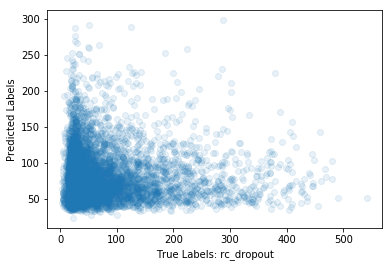

In [148]:
from matplotlib import pyplot as plt
plt.scatter(y_test_SPI1, spearmanr_all(y_test_SPI1, testing_model, keras_test_batch_generator_SPI1), alpha = 0.1)
plt.xlabel("True Labels: %s" % "rc_dropout")
plt.ylabel("Predicted Labels")
plt.show()

In [ ]:
import json
data = {
        "filename": "rc_orig_spatial_dropout_kernel_size_10",
        "dataset": "SPI1",
        "augment": False,
        "siamese": False,
        "rev_comp": True,
        "dropout": False,
        "mc_dropout": False,
        "spatial_dropout": True,
        "rc_spatial_dropout": False,
        "dropout_rate": 0.2,
        "num_conv": 3,
        "filters": 15,
        "kernel_size": 10,
        "pool_size": 80,
        "pooling": "max",
        "num_epochs": 300,
        "patience": 60,
        "seed_num": 1000,
        "strides": 40,
        "units": 100,
        "correlation": 0 
        }
test(data)

data["filename"] = "rc_rc_spatial_dropout_kernel_size_10"
data["spatial_dropout"] = False
data["rc_spatial_dropout"] = True
test(data)

data["filename"] = "rc_mc_dropout_kernel_size_10"
data["rc_spatial_dropout"] = False
data["mc_dropout"] = True
test(data)

data["filename"] = "rc_dropout_kernel_size_10"
data["mc_dropout"] = False 
data["dropout"] = True
test(data)

data["filename"] = "reg_dropout_kernel_size_10"
data["rev_comp"] = False
test(data)

data["filename"] = "reg_spatial_dropout_kernel_size_10"
data["dropout"] = False
data["spatial_dropout"] = True
test(data)

data["filename"] = "augment_spatial_dropout_kernel_size_10"
data["augment"] = True
test(data)

data["filename"] = "augment_dropout_kernel_size_10"
data["dropout"] = True
data["spatial_dropout"] = False
test(data)

data["filename"] = "siamese_dropout_kernel_size_10"
data["siamese"] = True
data["augment"] = False
test(data)

data["filename"] = "siamese_spatial_dropout_kernel_size_10"
data["dropout"] = False
data["spatial_dropout"] = True
test(data)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rev_comp_conv1d_31 (RevCompC (None, 1000, 30)          615       
_________________________________________________________________
activation_49 (Activation)   (None, 1000, 30)          0         
_________________________________________________________________
spatial_dropout1d_17 (Spatia (None, 1000, 30)          0         
_________________________________________________________________
rev_comp_conv1d_32 (RevCompC (None, 1000, 30)          4515      
_________________________________________________________________
activation_50 (Activation)   (None, 1000, 30)          0         
_________________________________________________________________
spatial_dropout1d_18 (Spatia (None, 1000, 30)          0         
_________________________________________________________________
rev_comp_conv1d_33 (RevCompC (None, 1000, 30)          4515      
__________

In [ ]:
data = {
        "filename": "rc_orig_spatial_dropout_10_filters",
        "dataset": "CTCF",
        "augment": False,
        "siamese": False,
        "rev_comp": True,
        "dropout": False,
        "mc_dropout": False,
        "spatial_dropout": True,
        "rc_spatial_dropout": False,
        "dropout_rate": 0.2,
        "num_conv": 3,
        "filters": 10,
        "kernel_size": 15,
        "pool_size": 40,
        "pooling": "max",
        "num_epochs": 300,
        "patience": 60,
        "seed_num": 1000,
        "strides": 40,
        "units": 100,
        "correlation": 0 
        }
test(data)

data["filename"] = "rc_rc_spatial_dropout_10_filters"
data["spatial_dropout"] = False
data["rc_spatial_dropout"] = True
test(data)

data["filename"] = "rc_mc_dropout_10_filters"
data["rc_spatial_dropout"] = False
data["mc_dropout"] = True
test(data)

data["filename"] = "rc_dropout_10_filters"
data["mc_dropout"] = False 
data["dropout"] = True
test(data)

data["filename"] = "reg_dropout_10_filters"
data["rev_comp"] = False
test(data)

data["filename"] = "reg_spatial_dropout_10_filters"
data["dropout"] = False
data["spatial_dropout"] = True
test(data)

data["filename"] = "augment_spatial_dropout_10_filters"
data["augment"] = True
test(data)

data["filename"] = "augment_dropout_10_filters"
data["dropout"] = True
data["spatial_dropout"] = False
test(data)

data["filename"] = "siamese_dropout_10_filters"
data["siamese"] = True
data["augment"] = False
test(data)

data["filename"] = "siamese_spatial_dropout_10_filters"
data["dropout"] = False
data["spatial_dropout"] = True
test(data)